
# Stanford Stats 191 

## Introduction

This is a re-creation of the Stanford Stats 191 course, using Python eco-system tools, instead of R. This is lecture "Poisson: " ( see https://web.stanford.edu/class/stats191/notebooks/Poisson.html )


In this notebook, we look at modelling count data.  The model is that of a Poisson process, where events occur in a fixed interval of time or space if these events occur with a constant mean rate and independently of the time since the last event.  The probability we get ```x``` events in a unit time is shown below

$$P(X=x)=\dfrac{\lambda^x e^{-\lambda}}{x!}\qquad x=0,1,2,\ldots$$

## Initial Notebook Setup

```watermark``` documents the Python and package environment, ```black``` is my chosen Python formatter

In [2]:
%load_ext watermark

In [3]:
%reload_ext lab_black

In [4]:
%matplotlib inline

In [66]:
import pandas as pd
import numpy as np
import seaborn as sn

import math

import warnings

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from statsmodels.formula.api import logit
from statsmodels.formula.api import probit
from statsmodels.formula.api import glm


import statsmodels.api as sm

from scipy import stats

import os

----
## Simple Contingency Table

We wish to test if Males and Females answer a question differently

First, create a ```pandas``` dataframe from the survey data

In [33]:
data_dict = {'Y': [435, 375], 'N': [147, 134]}

df = pd.DataFrame(data_dict)
df.head()

,Y,N
0,435,147
1,375,134


Give names to vertical and horizontal indexes

In [34]:
df.index = pd.Index(['M', 'F'], name='Gender')
df.columns = pd.Index(['Y', 'N'], name='Response')

In [35]:
df

Response,Y,N
Gender,,
M,435,147
F,375,134


Get the data as a ```numpy``` array, and then process with the ```Table``` object

In [42]:
tab0 = np.asarray([df['Y'], df['N']])

In [43]:
tab0

array([[435, 375],
       [147, 134]], dtype=int64)

In [48]:
tab1 = sm.stats.Table(tab0.T)

In [49]:
print(tab1)

A 2x2 contingency table with counts:
[[435. 147.]
 [375. 134.]]


In [56]:
tab1.table_orig

array([[435, 147],
       [375, 134]], dtype=int64)

In [58]:
tab1.fittedvalues

array([[432.09899175, 149.90100825],
       [377.90100825, 131.09899175]])

Show the contributions to the Chi-squared statistic

In [59]:
tab1.chi2_contribs

array([[0.01947667, 0.05614271],
       [0.02226998, 0.06419461]])

Assess the indepedence between rows and columns (both as nominal and ordinal variables)

In [62]:
print(tab1.test_nominal_association())

df          1
pvalue      0.6872450563829144
statistic   0.16208397298431804


In [63]:
print(tab1.test_ordinal_association())

null_mean   131.09899175068745
null_sd     7.209050259693882
pvalue      0.6873808486214543
statistic   134.0
zscore      0.4024119883769182


Get the Chi-squared value; we see that it is quiet likely that we would get the observed value by chance

In [69]:
tab1_chi2 = sum(sum(tab1.chi2_contribs))

In [95]:
1 - stats.chi2.cdf(tab1_chi2, 1)

0.6872450563829144

In [71]:
tab1_chi2

0.16208397298431804

I found the Chi-squared curve for degree-of-freedom = 1 to be quiet counter-intuitive.  It was only when I plotted out the PDF and CDF, that I realized that a lot of the probability mass is concentrated near zero

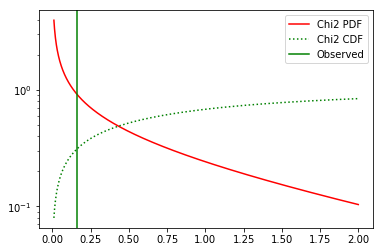

In [94]:
x = list(np.linspace(0.01, 2, 1000))
y = [stats.chi2.pdf(x1, 1) for x1 in x]
y2 = [stats.chi2.cdf(x1, 1) for x1 in x]
_ = plt.yscale('log')
_ = plt.plot(x, y, 'r-', label='Chi2 PDF')
_ = plt.plot(x, y2, 'g:', label='Chi2 CDF')
_ = plt.axvline(tab1_chi2, color='green', label='Observed')
_ = plt.legend(loc='best')

```statsmodels``` also has a specific Object for 2 by 2 tables, as below

In [52]:
tab2 = sm.stats.Table2x2(tab0.T)

In [54]:
tab2.summary()

,Estimate,SE,LCB,UCB,p-value
Odds ratio,1.057,,0.806,1.388,0.687
Log odds ratio,0.056,0.139,-0.216,0.328,0.687
Risk ratio,1.015,,0.946,1.088,0.688
Log risk ratio,0.014,0.036,-0.056,0.085,0.688


----
## scipy

```scipy``` also has Chi-squared analysis methods, that are a little more advanced than ```statsmodels```, in that they offer a variety of correction methods to estimate Chi-squared

With Yates correction

In [105]:
chi2, p_value, dof, expected = stats.chi2_contingency(
    tab0.T
)
print(f' chi2 = {chi2}, P value = {p_value}')

 chi2 = 0.1110272160868229, P value = 0.7389776820172238


Without Yates correction

In [107]:
chi2, p_value, dof, expected = stats.chi2_contingency(
    tab0.T, correction=False
)
print(f' chi2 = {chi2}, P value = {p_value}')

 chi2 = 0.1620839729843177, P value = 0.6872450563829149


In [103]:
odds_ratio, p_value = stats.fisher_exact(tab0.T)
print(p_value)

0.7286890678300681


------
## Poisson Regression

We can also treat this as a case of regression, where we assume the rate of ```Y``` or ```N``` answers might depend upon gender

We build a dataframe with the data, one row per observation

In [108]:
data_dict2 = {
    'Y': [435, 147, 375, 134],
    'S': ['M', 'M', 'F', 'F'],
    'B': ['Y', 'N', 'Y', 'N'],
}

In [110]:
df2 = pd.DataFrame(data_dict2)
df2

,Y,S,B
0,435,M,Y
1,147,M,N
2,375,F,Y
3,134,F,N


Now fit a Poisson model.  We get the same Chi-squared value as before

In [111]:
res = glm(
    'Y ~ S + B', data=df2, family=sm.families.Poisson()
).fit()

In [112]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                    4
Model:                            GLM   Df Residuals:                        1
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14.704
Date:                Fri, 22 May 2020   Deviance:                      0.16200
Time:                        20:33:01   Pearson chi2:                    0.162
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8760      0.068     71.839      0.000       4.743       5.009
S[T.M]         0.1340      0.061      2.208      0.027       0.015       0.253
B[T.Y]         1.0587      0.069     15.291      0.000       0.923       1.194
==============================================================================
"""

In [115]:
res.fittedvalues

0    432.098992
1    149.901008
2    377.901008
3    131.098992
dtype: float64

-----
## Lumber Dataset

Finally, we look at a dataset, relating to customers travelling to a lumber store from different regions

| Column | Definition |
| ---- | ----- |
|Customers  | number of customers visting store from region|
|Housing  | number of housing units in region|
|Income  | average household income|
|Age  | average housing unit age in region|
|Competitor  | distance to nearest competitor|
|Store  | distance to store in miles.|

### Read and Explore Dataset

In [118]:
lumber = pd.read_fwf(
    '../data/lumber.txt', widths=[2, 6, 8, 4, 6, 6]
)
lumber.columns = [
    'Customers',
    'Housing',
    'Income',
    'Age',
    'Competitor',
    'Store',
]

In [119]:
lumber.head()

,Customers,Housing,Income,Age,Competitor,Store
0,9,606,41393,3,3.04,6.32
1,6,641,23635,18,1.95,8.89
2,28,505,55475,27,6.54,2.05
3,11,866,64646,31,1.67,5.81
4,4,599,31972,7,0.72,8.11


Perform a Poisson Regression, using the Generalized Linear Model formula interface

In [120]:
res2 = glm(
    'Customers ~ Housing + Income + Age + Competitor + Store',
    data=lumber,
    family=sm.families.Poisson(),
).fit()

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Customers   No. Observations:                  110
Model:                            GLM   Df Residuals:                      104
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.51
Date:                Fri, 22 May 2020   Deviance:                       114.99
Time:                        20:45:16   Pearson chi2:                     102.
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9424      0.207     14.198      0.000       2.536       3.349
Housing        0.0006      0.000      4.262      0.000       0.000       0.001
Income     -1.169e-05   2.11e-06     -5.534      0.000   -1.58e-05   -7.55e-06
Age           -0.0037      0.002     -2.091      0.037      -0.007      -0.000
Competitor     0.1684      0.026      6.534      0.000       0.118       0.219
Store         -0.1288      0.016     -7.948      0.000      -0.161      -0.097
==============================================================================
"""

Show AIC value matches STATS191 notes

In [121]:
res2.aic

571.0242714424356

Plot the Residuals against Fitted Values (seems OK)

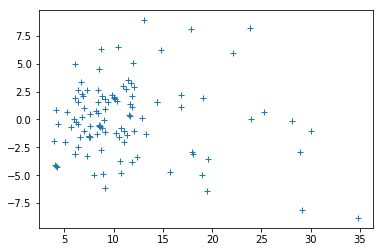

In [126]:
_ = plt.plot(
    res2.fittedvalues,
    lumber['Customers'] - res2.fittedvalues,
    '+',
)

We can also use the Object interface, but have to specify regularized fitting

In [145]:
y = np.array(lumber['Customers'])


x = np.array(
    lumber[
        ['Housing', 'Income', 'Age', 'Competitor', 'Store']
    ]
)
X = sm.add_constant(x)

In [149]:
res3 = sm.Poisson(y, X).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.5410194156558066
            Iterations: 17
            Function evaluations: 39
            Gradient evaluations: 17


In [150]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:                        Poisson   Df Residuals:                      104
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 May 2020   Pseudo R-squ.:                  0.3547
Time:                        21:11:48   Log-Likelihood:                -279.51
converged:                       True   LL-Null:                       -433.13
                                        LLR p-value:                 2.789e-64
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9424      0.207     14.198      0.000       2.536       3.349
x1             0.0006      0.000      4.262      0.000       0.000       0.001
x2         -1.169e-05   2.11e-06     -5.534      0.000   -1.58e-05   -7.55e-06
x3            -0.0037      0.002     -2.091      0.037      -0.007      -0.000
x4             0.1684      0.026      6.534      0.000       0.118       0.219
x5            -0.1288      0.016     -7.948      0.000      -0.161      -0.097
==============================================================================
"""

In [152]:
res3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Poisson
=================================================================
Model:              Poisson          Pseudo R-squared: 0.355     
Dependent Variable: y                AIC:              571.0243  
Date:               2020-05-22 21:15 BIC:              587.2272  
No. Observations:   110              Log-Likelihood:   -279.51   
Df Model:           5                LL-Null:          -433.13   
Df Residuals:       104              LLR p-value:      2.7887e-64
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     17.0000                                      
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      2.9424     0.2072   14.1977   0.0000    2.5362    3.3486
x1         0.0006     0.0001    4.2623   0.0000    0.0003    0.0009
x2        -0.0000     0.0000   -5.5340   0.0000   -0.0000   -0.0000
x3        -0.0037     0.0018   -2.0913   0.0365   -0.0072   -0.0002
x4         0.1684     0.0258    6.5343   0.0000    0.1179    0.2189
x5        -0.1288     0.0162   -7.9481   0.0000   -0.1605   -0.0970
=================================================================

"""

The bare-bones call to the Poisson object fails.  I don't really know why this interface fails

In [166]:
res4 = sm.Poisson(y, X).fit()

         Current function value: 29876812607532474166702938553126939000832.000000
         Iterations: 35


D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


----------------
# Conclusions

This concludes my sweep through the STATS191 lecture notes, and I must say that I have learned a lot.  Obviously I would have to learn a lot more to be even close to being a statistician, and I suspect that analysing hundreds of datasets would be needed to gain a deep understanding of strengths and weaknesses of the various techniques


---------
## Reproducibility

In [218]:
%watermark -h -iv
%watermark

seaborn     0.9.0
matplotlib  3.0.2
numpy       1.15.4
statsmodels 0.9.0
pandas      1.0.0
scipy       1.1.0
host name: DESKTOP-SODFUN6
2020-05-21T18:49:21+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [219]:
sm.show_versions()


INSTALLED VERSIONS
------------------
Python: 3.7.1.final.0

Statsmodels

Installed: 0.9.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels)

Required Dependencies

cython: 0.29.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\Cython)
numpy: 1.15.4 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\numpy)
scipy: 1.1.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy)
pandas: 1.0.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\pandas)
    dateutil: 2.7.5 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\dateutil)
patsy: 0.5.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\patsy)

Optional Dependencies

matplotlib: 3.0.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: Not installed
joblib: 0.13.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\joblib)

Developer Tools

IPython: 7.2.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\IPython)
    jinja2: 2.10.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\jinja2)
sphinx: